In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.feature_extraction import DictVectorizer  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [4]:
df = pd.read_csv('CreditScoring.csv')

df.columns = df.columns.str.lower()


In [5]:
# clean data

# status

# make all column lowercase
df.columns = df.columns.str.lower()

In [6]:
# some of the features are encoded as numbers but are actually categorical

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}  

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'    
}
df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'    
}
df.marital = df.marital.map(marital_values)

record_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'    
}

df.records = df.records.map(record_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'other',
    0: 'unk'    
}
df.job = df.job.map(job_values)

In [7]:
# relplace missing values

for c in ['income', 'assets', 'debt']:
   df[c] = df[c].replace(to_replace=99999999, value=np.nan).max()

In [8]:
df.describe().round(2)

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.00,4455.00,4455.00,4455.00,4455.0,4455.0,4455.0,4455.00,4455.00
mean,7.99,46.44,37.08,55.57,959.0,300000.0,30000.0,1039.02,1462.88
std,8.17,14.66,10.98,19.52,0.0,0.0,0.0,474.54,628.09
min,0.00,6.00,18.00,35.00,959.0,300000.0,30000.0,100.00,105.00
25%,2.00,36.00,28.00,35.00,959.0,300000.0,30000.0,700.00,1117.50
50%,5.00,48.00,36.00,51.00,959.0,300000.0,30000.0,1000.00,1400.00
75%,12.00,60.00,45.00,72.00,959.0,300000.0,30000.0,1300.00,1692.00
max,48.00,72.00,68.00,180.00,959.0,300000.0,30000.0,5000.00,11140.00


In [9]:
df[df.status != 'unk'].reset_index(drop=True)


,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,959.0,300000.0,30000.0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,959.0,300000.0,30000.0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,959.0,300000.0,30000.0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,959.0,300000.0,30000.0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,959.0,300000.0,30000.0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,default,1,rent,60,39,married,no,fixed,69,959.0,300000.0,30000.0,900,1020
4450,ok,22,owner,60,46,married,no,fixed,60,959.0,300000.0,30000.0,950,1263
4451,default,0,owner,24,37,married,no,partime,60,959.0,300000.0,30000.0,500,963
4452,ok,0,rent,48,23,single,no,freelance,49,959.0,300000.0,30000.0,550,550


In [10]:
#split data

df_full_train, df_test =  train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)


In [11]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = (df_train.status == 'default').astype(int).values
y_val = (df_val.status == 'default').astype(int).values
y_test = (df_test.status == 'default').astype(int).values



In [13]:
del df_train['status']
del df_val['status']
del df_test['status']

In [14]:
# train model

tran_dicts = df_train.fillna(0).to_dict(orient='records')

In [15]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(tran_dicts)

In [16]:
# where dt stands for decision tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [17]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = dt.predict_proba(X_val)[:, 1]

In [18]:
# roc auc score for validation set

roc_auc = roc_auc_score(y_val, y_pred)


In [19]:
# roc auc score for train set

y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_train = roc_auc_score(y_train, y_pred)
roc_auc_train

1.0

In [20]:
# print decision tree rules
# print(export_text(dt, feature_names=dv.get_feature_names_out().tolist()))

In [21]:
# decision tree algorithm
# Finding the best split for one column
# Finding the best split for the entire dataset
# stopping criteria
# Decision tree leanring algorithms 


In [22]:
# Parameter tuning for decision trees

# tuning max_depth parameter
t = [1,2,3,4,5,6,10,15,20,None]

for max_depth in t:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print(f'max_depth={max_depth} => ROC AUC={auc:.3f}')

max_depth=1 => ROC AUC=0.613
max_depth=2 => ROC AUC=0.688
max_depth=3 => ROC AUC=0.737
max_depth=4 => ROC AUC=0.758
max_depth=5 => ROC AUC=0.763
max_depth=6 => ROC AUC=0.749
max_depth=10 => ROC AUC=0.684
max_depth=15 => ROC AUC=0.669
max_depth=20 => ROC AUC=0.653
max_depth=None => ROC AUC=0.643


In [23]:
# Tuning min_samples_leaf
min_samples_leaf_values = [4,5,6]
for d in min_samples_leaf_values:
    for s in [1,2,5,10,15,20,100,200,500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        print(f'max_depth={d}, min_samples_leaf={s} => ROC AUC={auc:.3f}')
    

max_depth=4, min_samples_leaf=1 => ROC AUC=0.758
max_depth=4, min_samples_leaf=2 => ROC AUC=0.758
max_depth=4, min_samples_leaf=5 => ROC AUC=0.758
max_depth=4, min_samples_leaf=10 => ROC AUC=0.757
max_depth=4, min_samples_leaf=15 => ROC AUC=0.756
max_depth=4, min_samples_leaf=20 => ROC AUC=0.757
max_depth=4, min_samples_leaf=100 => ROC AUC=0.751
max_depth=4, min_samples_leaf=200 => ROC AUC=0.750
max_depth=4, min_samples_leaf=500 => ROC AUC=0.649
max_depth=5, min_samples_leaf=1 => ROC AUC=0.761
max_depth=5, min_samples_leaf=2 => ROC AUC=0.763
max_depth=5, min_samples_leaf=5 => ROC AUC=0.767
max_depth=5, min_samples_leaf=10 => ROC AUC=0.765
max_depth=5, min_samples_leaf=15 => ROC AUC=0.762
max_depth=5, min_samples_leaf=20 => ROC AUC=0.762
max_depth=5, min_samples_leaf=100 => ROC AUC=0.761
max_depth=5, min_samples_leaf=200 => ROC AUC=0.756
max_depth=5, min_samples_leaf=500 => ROC AUC=0.649
max_depth=6, min_samples_leaf=1 => ROC AUC=0.746
max_depth=6, min_samples_leaf=2 => ROC AUC=0.745
ma

In [24]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [25]:
# ensemble and random forest
#board expert
# ensembling method
# random forest -ensemble of decision trees
# tuning random forestB

# we can combine different models and based on the probability scores we can make the final decision


rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [26]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred)

roc_auc

0.7576762382724136

In [27]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))
    print(f'n_estimators={n} => ROC AUC={auc:.3f}')

n_estimators=10 => ROC AUC=0.758
n_estimators=20 => ROC AUC=0.776
n_estimators=30 => ROC AUC=0.777
n_estimators=40 => ROC AUC=0.775
n_estimators=50 => ROC AUC=0.778
n_estimators=60 => ROC AUC=0.780
n_estimators=70 => ROC AUC=0.782
n_estimators=80 => ROC AUC=0.784
n_estimators=90 => ROC AUC=0.783
n_estimators=100 => ROC AUC=0.783
n_estimators=110 => ROC AUC=0.783
n_estimators=120 => ROC AUC=0.783
n_estimators=130 => ROC AUC=0.782
n_estimators=140 => ROC AUC=0.784
n_estimators=150 => ROC AUC=0.783
n_estimators=160 => ROC AUC=0.783
n_estimators=170 => ROC AUC=0.783
n_estimators=180 => ROC AUC=0.782
n_estimators=190 => ROC AUC=0.783
n_estimators=200 => ROC AUC=0.782


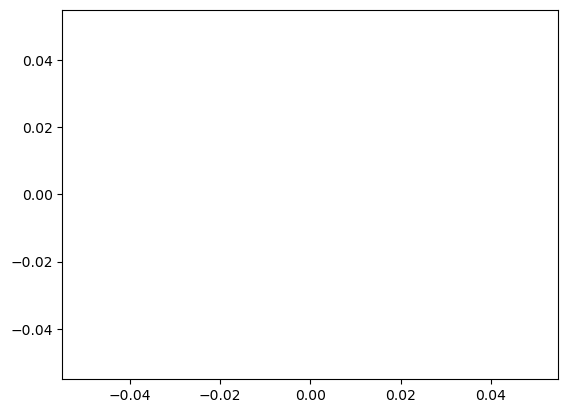

In [71]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'roc_auc'])
plt.plot(df_scores.n_estimators, df_scores.roc_auc)
# num_iter	train_auc	val_auc

In [29]:
scores = []

for d in [5,10,15]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))
        print(f'max_depth={d}, n_estimators={n} => ROC AUC={auc:.3f}')

max_depth=5, n_estimators=10 => ROC AUC=0.784
max_depth=5, n_estimators=20 => ROC AUC=0.782
max_depth=5, n_estimators=30 => ROC AUC=0.782
max_depth=5, n_estimators=40 => ROC AUC=0.787
max_depth=5, n_estimators=50 => ROC AUC=0.792
max_depth=5, n_estimators=60 => ROC AUC=0.793
max_depth=5, n_estimators=70 => ROC AUC=0.792
max_depth=5, n_estimators=80 => ROC AUC=0.793
max_depth=5, n_estimators=90 => ROC AUC=0.792
max_depth=5, n_estimators=100 => ROC AUC=0.793
max_depth=5, n_estimators=110 => ROC AUC=0.793
max_depth=5, n_estimators=120 => ROC AUC=0.792
max_depth=5, n_estimators=130 => ROC AUC=0.792
max_depth=5, n_estimators=140 => ROC AUC=0.794
max_depth=5, n_estimators=150 => ROC AUC=0.794
max_depth=5, n_estimators=160 => ROC AUC=0.793
max_depth=5, n_estimators=170 => ROC AUC=0.794
max_depth=5, n_estimators=180 => ROC AUC=0.794
max_depth=5, n_estimators=190 => ROC AUC=0.794
max_depth=5, n_estimators=200 => ROC AUC=0.794
max_depth=10, n_estimators=10 => ROC AUC=0.782
max_depth=10, n_estima

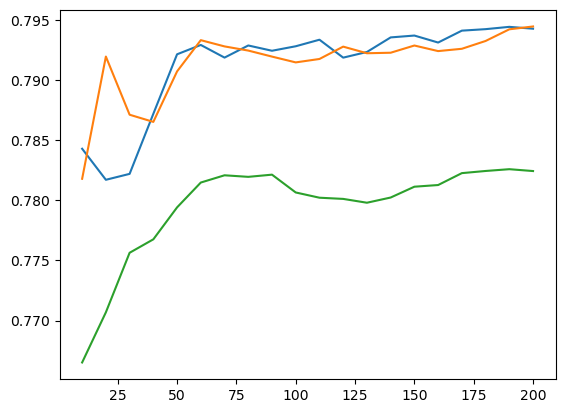

In [30]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'roc_auc'])

for d in [5,10,15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.roc_auc, label=f'max_depth={d}')

In [31]:
scores = []
max_depth = 10
for s in [1,3,5,10,50]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))
        print(f'max_depth={d}, n_estimators={n} => ROC AUC={auc:.3f}')

max_depth=15, n_estimators=10 => ROC AUC=0.782
max_depth=15, n_estimators=20 => ROC AUC=0.792
max_depth=15, n_estimators=30 => ROC AUC=0.787
max_depth=15, n_estimators=40 => ROC AUC=0.787
max_depth=15, n_estimators=50 => ROC AUC=0.791
max_depth=15, n_estimators=60 => ROC AUC=0.793
max_depth=15, n_estimators=70 => ROC AUC=0.793
max_depth=15, n_estimators=80 => ROC AUC=0.792
max_depth=15, n_estimators=90 => ROC AUC=0.792
max_depth=15, n_estimators=100 => ROC AUC=0.791
max_depth=15, n_estimators=110 => ROC AUC=0.792
max_depth=15, n_estimators=120 => ROC AUC=0.793
max_depth=15, n_estimators=130 => ROC AUC=0.792
max_depth=15, n_estimators=140 => ROC AUC=0.792
max_depth=15, n_estimators=150 => ROC AUC=0.793
max_depth=15, n_estimators=160 => ROC AUC=0.792
max_depth=15, n_estimators=170 => ROC AUC=0.793
max_depth=15, n_estimators=180 => ROC AUC=0.793
max_depth=15, n_estimators=190 => ROC AUC=0.794
max_depth=15, n_estimators=200 => ROC AUC=0.794
max_depth=15, n_estimators=10 => ROC AUC=0.780
ma

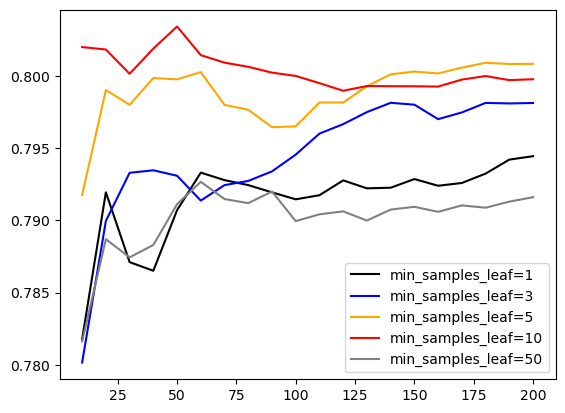

In [32]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1,3,5,10,50]
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'n_estimators', 'roc_auc'])

for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.roc_auc,color=col, label=f'min_samples_leaf={s}')
    
plt.legend()

In [33]:
min_samples_leaf = 3
max_depth = 10
rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth, min_samples_leaf=s, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=50, n_estimators=200,
                       random_state=1)

In [ ]:
# Gradient Boosting and XGBoost
features = dv.get_feature_names_out().tolist()
d_train = xgb.DMatrix(X_train, label=y_train, feature_names=features)
d_val = xgb.DMatrix(X_val, label=y_val, feature_names=features)

,n_estimators,roc_auc


In [35]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
    
}

model = xgb.train(xgb_params, d_train, num_boost_round=10)

In [36]:
y_pred = model.predict(d_val)

In [37]:
roc_auc = roc_auc_score(y_val, y_pred)
roc_auc

0.7903898688488113

In [38]:
%%capture output

watchlist = [(d_train, 'train'), (d_val, 'val')]
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'eval_metric': 'auc',
    'verbosity': 1,
}

model = xgb.train(xgb_params, d_train, num_boost_round=200, evals=watchlist, verbose_eval=5)

In [39]:
output.show()

[0]	train-auc:0.83707	val-auc:0.75860
[5]	train-auc:0.90323	val-auc:0.78435
[10]	train-auc:0.91931	val-auc:0.79240
[15]	train-auc:0.93518	val-auc:0.79252
[20]	train-auc:0.94859	val-auc:0.78796
[25]	train-auc:0.95705	val-auc:0.78554
[30]	train-auc:0.96338	val-auc:0.78335
[35]	train-auc:0.97035	val-auc:0.78463
[40]	train-auc:0.97375	val-auc:0.78395
[45]	train-auc:0.97931	val-auc:0.78378
[50]	train-auc:0.98440	val-auc:0.78427
[55]	train-auc:0.98592	val-auc:0.78401
[60]	train-auc:0.98875	val-auc:0.77950
[65]	train-auc:0.99161	val-auc:0.78006
[70]	train-auc:0.99331	val-auc:0.78096
[75]	train-auc:0.99474	val-auc:0.78152
[80]	train-auc:0.99586	val-auc:0.78019
[85]	train-auc:0.99645	val-auc:0.77871
[90]	train-auc:0.99759	val-auc:0.77690
[95]	train-auc:0.99816	val-auc:0.77566
[100]	train-auc:0.99868	val-auc:0.77433
[105]	train-auc:0.99879	val-auc:0.77478
[110]	train-auc:0.99918	val-auc:0.77175
[115]	train-auc:0.99954	val-auc:0.77091
[120]	train-auc:0.99964	val-auc:0.77053
[125]	train-auc:0.9998

In [56]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [57]:
df_score = parse_xgb_output(output)


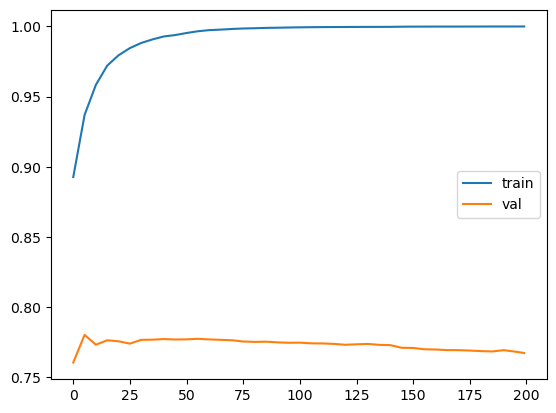

In [58]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

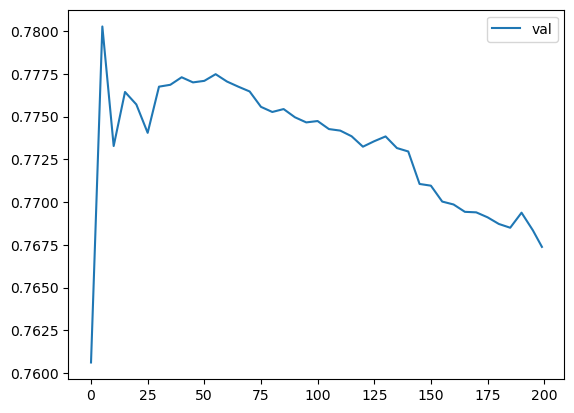

In [59]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [60]:
# 6.8 XGBoost parameter tuning
# eta alias learning_rate
# max_depth
# min_child_weight

In [61]:
scores = {}


In [62]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, d_train, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [63]:
scores = {}


In [64]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [65]:
scores = {}

In [66]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, d_train, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)


In [67]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=10'

In [68]:
del scores['max_depth=10']


/var/folders/c2/p1f3lfts057c3b_hln9377n00000gn/T/ipykernel_10199/1811656557.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


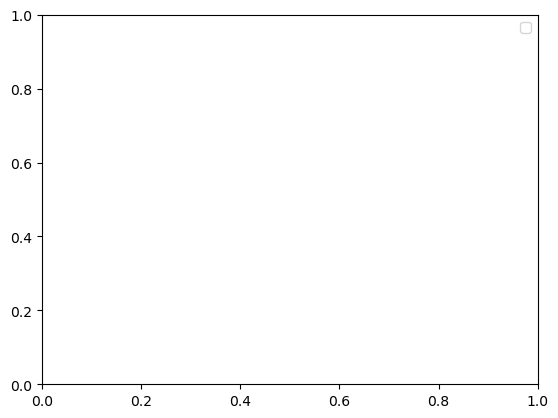

In [ ]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)

# plt.ylim(0.8, 0.84)
plt.legend()

In [54]:
scores = {}


In [ ]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, d_train, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

/var/folders/c2/p1f3lfts057c3b_hln9377n00000gn/T/ipykernel_10199/4062915789.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


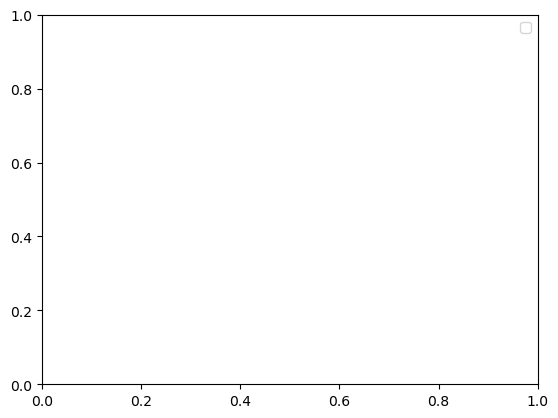

In [55]:
for min_child_weight , df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
    
plt.legend()

for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()

In [73]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, d_train, num_boost_round=175)

In [81]:
# Selecting the best model and evaluating it on the test set


#xgoost model

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, d_train, num_boost_round=175)

y_pred = model.predict(d_val)
roc_auc = roc_auc_score(y_val, y_pred)
roc_auc

0.8059988380573309

In [82]:
# Random forest model

rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred)
roc_auc

0.7834491155638512

In [83]:
# Decision tree model

dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred)
roc_auc

0.767283897205157

In [87]:
# train best model on full train set

df_full_train = df_full_train.reset_index(drop=True)
y_full_train = (df_full_train.status == 'default').astype(int).values
del df_full_train['status']

In [88]:
dicts_full_train = df_full_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [89]:
dfulltrain = xgb.DMatrix(X_full_train, label= y_full_train, feature_names=dv.get_feature_names_out().tolist())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [90]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [ ]:
y_pred = model.predict(dtest)

roc_auc_score(y_test, y_pred)

# XGBOOST FOR DATAFRAME DATA

0.814493957613646